In [1]:
import calitp
from calitp.tables import tbl
from siuba import *
from siuba.sql import sql_raw
from siuba.experimental import completer
from plotnine import *
import pandas as pd
import numpy as np

/Users/edasmalchi/anaconda3/envs/pd1/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## About how many validators are needed to connect to LOSSAN?

In [110]:
# eng = calitp.get_engine()

In [33]:
transit_stacks = tbl.views.transitstacks()

In [34]:
lossan_counties = ['San Luis Obispo', 'Santa Barbara', 'Ventura',
                  'Los Angeles', 'San Diego']

In [28]:
dim_stops = (tbl.views.gtfs_schedule_dim_stops()
                 >> select(_.itp_id == _.calitp_itp_id, _.stop_key, _.stop_id, _.stop_lat, _.stop_lon, _.stop_name)
            #      >> head(5)
                )

In [36]:
weekday_stops = (tbl.views.gtfs_schedule_fact_daily_feed_stops()
                    >> filter(_.date == '2021-09-01') #weekday service
                    >> select(_.stop_key, _.date)
                    >> inner_join(_, dim_stops, on='stop_key')
#                     >> head(5)
                      )

In [125]:
info_cols = ['itp_id',
                 'transit_provider',
                 'ntd_id',
                 'modes',
                 'county',
                 'legacy_ntd_id']

vehicle_cols = [
                 'bus',
                 'articulated_bus',
                 'over_the_road_bus',
                 'school_bus',

                 'trolleybus',
#                  'heavy_rail_passenger_car',
#                  'light_rail_vehicle',
#                  'commuter_rail_passenger_coach',
#                  'commuter_rail_self_propelled_passenger_car',
#                  'locomotive',
#                  'automated_guideway_vehicle',
                 'vintage_historic_trolley',
                 'streetcar']

paratransit_cols = [
                     'van',
                     'cutaway',
                     'automobile',
                     'minivan',
                     'sport_utility_vehicle']

In [126]:
lossan_stops = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(_.itp_id)
                         >> inner_join(_, weekday_stops, on = "itp_id")
#                          >> select(*(info_cols + vehicle_cols))
#                          >> head(5)
                         >> collect()
                    )

In [127]:
lossan_operators = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                    #      >> inner_join(_, weekday_stops, on = "itp_id")
                         >> select(*(info_cols + vehicle_cols))
#                          >> gather(*vehicle_cols, -_.itp_id)
#                          >> head(5)
                         >> collect()
                    )

In [128]:
lossan_operators.replace(' ', np.nan, inplace=True)
for col in vehicle_cols:
    lossan_operators = lossan_operators.astype({col:'float64'})
# lossan_operators

In [129]:
lossan_operators[vehicle_cols].sum()

bus                         4351.0
articulated_bus              584.0
over_the_road_bus            229.0
school_bus                     0.0
trolleybus                     0.0
vintage_historic_trolley       2.0
streetcar                      0.0
dtype: float64

### Buses, in all counties...

In [137]:
validators_needed = {'bus':2, 'articulated_bus':3, 'over_the_road_bus':1,
                     'vintage_historic_trolley':2,
                     'lrt_stn':6, 'hrt_stn':15, 'la_union_stn':40,
                     'commuter_rail_stn':6, 'interchange':20}

In [138]:
(pd.Series(validators_needed) * lossan_operators[vehicle_cols].sum()).dropna()


articulated_bus             1752.0
bus                         8702.0
over_the_road_bus            229.0
vintage_historic_trolley       4.0
dtype: float64

## Rail!

In [123]:
lossan_operators[['itp_id', 'transit_provider']]

,itp_id,transit_provider
0,352,UC San Diego Campus Shuttles
1,353,USC Transportation
2,202,Mission City Transit
3,213,Morro Bay Transit
4,59,Catalina Flyer
...,...,...
124,328,Whittier Dial-A-Ride
125,69,Claremont Dial-a-Ride
126,20,Artesia Express Dial-A-Ride
127,160,DASH Transit


In [124]:
tbl.views.gtfs_schedule_dim_routes() >> head(5)

,route_key,calitp_itp_id,calitp_url_number,route_id,route_type,agency_id,route_short_name,route_long_name,route_desc,route_url,...,route_continuous_drop_off,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_fare_url,agency_email,calitp_extracted_at,calitp_deleted_at
0,-9068512898515523435,238,0,15729,3,75,None,Community Circular Response Route,None,None,...,1,Palo Verde Valley Transit Agency,http://pvvta.com/,America/Los_Angeles,en,(760) 922-1140,None,None,2021-04-15,2099-01-01
1,2604161650835279359,293,0,20,3,1,20,Carpinteria,None,None,...,None,SBMTD,https://sbmtd.gov,America/Los_Angeles,en,805-963-3364,https://sbmtd.gov/fares-passes/,info@sbmtd.gov,2021-04-15,2099-01-01
2,-3013574181432666764,293,0,2430,3,1,2430,La Colina Jr. High,None,None,...,None,SBMTD,https://sbmtd.gov,America/Los_Angeles,en,805-963-3364,https://sbmtd.gov/fares-passes/,info@sbmtd.gov,2021-07-15,2099-01-01
3,2413331032151217230,293,0,7,3,1,7,County Health/Fairview,None,None,...,None,SBMTD,https://sbmtd.gov,America/Los_Angeles,en,805-963-3364,https://sbmtd.gov/fares-passes/,info@sbmtd.gov,2021-04-15,2099-01-01
4,-4676294777311645706,293,0,2530,3,1,2530,San Marcos High School,None,None,...,None,SBMTD,https://sbmtd.gov,America/Los_Angeles,en,805-963-3364,https://sbmtd.gov/fares-passes/,info@sbmtd.gov,2021-04-15,2021-05-24


In [ ]:
##TODO replace hardcoded station values

metro_lrt
metro_hrt
metrolink
coaster
sdmts_lrt

## Direct LOSSAN Connections

In [ ]:
## LOSSAN station locations...

## Scratchpad

In [58]:
lossan_stops

,itp_id,stop_name,date,stop_lon,stop_lat,stop_key,stop_id
0,260,Airport Blvd. / Century Blvd.,2021-09-01,-118.385867,33.946301,7240031012082528129,171
1,260,Diamond St. / Lucia Ave.,2021-09-01,-118.381579,33.849346,-1917522574873626654,308
2,260,Main St / Mariposa Ave.,2021-09-01,-118.416074,33.923753,-1687249318440141690,221
3,260,Rindge Ln. / Ripley Ave.,2021-09-01,-118.372641,33.861636,3098617143585669701,314
4,260,Rosecrans Ave. / Sepulveda Blvd.,2021-09-01,-118.395432,33.901741,9086599303417023959,136
...,...,...,...,...,...,...,...
44558,243,Allen Ave & Colorado Blvd,2021-09-01,-118.113232,34.145463,-2012458046063568106,18
44559,243,Washington Blvd & Lake Ave,2021-09-01,-118.131784,34.168913,-6589317956151772312,201
44560,243,Lake Ave & Orange Grove Blvd,2021-09-01,-118.132599,34.157458,-3827411166724682000,211
44561,243,Del Mar Blvd & Mentor Ave,2021-09-01,-118.130490,34.140845,9000941398159293524,117


In [60]:
import geopandas as gpd
import folium

In [62]:
geo_stops = gpd.GeoDataFrame(
                lossan_stops,
                geometry = gpd.points_from_xy(lossan_stops.stop_lon, lossan_stops.stop_lat),
                crs='EPSG:4326')

<AxesSubplot:>

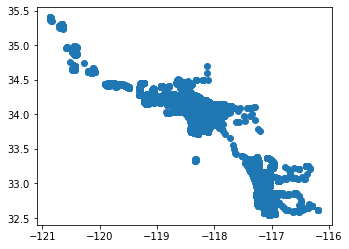

In [63]:
geo_stops.plot()

In [74]:
# m = folium.Map(location=[34, -118])
## hella slow
# folium.GeoJson(geo_stops.drop(columns=['date']).to_json(), name="geojson").add_to(m)